# Classical Equivalent Layer Magnetic 

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import string as st
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_classical_mag.ipynb'

#### Black background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../'
sys.path.append(dir_modules)

In [6]:
import auxiliary_functions as fc

In [7]:
import eql_functions as func

#### Loading properties of the model

In [8]:
with open('data/model_poly_remanent.pickle') as f:
        model_poly_remanent = pickle.load(f)

In [9]:
with open('data/model_poly_induced.pickle') as f:
        model_poly_induced = pickle.load(f)

#### Loading properties grid

In [10]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [11]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

### Saving files

In [12]:
saved_files = []

## Observation area

In [13]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 6000.0 m 
 x_min = -6000.0 m 
 y_max = 6000.0 m 
 y_min = -6000.0 m


### Airborne survey information

In [14]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']
print 'Height: %.1f m' % airborne['z_obs']

Shape : (50,25)
Number of data: 1250.0
dx: 244.9 m
dy: 500.0 m 
Height: -100.0 m


## Properties of the model

### Top and bottom of the polyprism

In [15]:
print 'Properties of a polyprism :\n Top = %.1f m \n Bottom = %.1f m \n Vertices = %.f ' %  (model_poly_remanent['z_top'],
                                                                                             model_poly_remanent['z_bottom'],
                                                                                             len(model_poly_remanent['verts']))

Properties of a polyprism :
 Top = 800.0 m 
 Bottom = 3000.0 m 
 Vertices = 7 


### Main field

In [16]:
inc_gf,dec_gf = model_poly_induced['main_field']

In [17]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

#### Sphere w/ the presence of a Remanent magnetization

In [18]:
print 'Intensity: %.1f A/m' % model_poly_induced['m_I']
print 'Inclination: %.1f degree' % model_poly_induced['inc_I']
print 'Declination: %.1f degree' % model_poly_induced['dec_I']

Intensity: 5.0 A/m
Inclination: 40.0 degree
Declination: 45.0 degree


In [19]:
inc_I,dec_I = model_poly_induced['inc_I'],model_poly_induced['dec_I']

## Generating the layer with my function 

In [20]:
h = 400.

#### Generating a layer

In [21]:
shape_layer = (40,25)

In [22]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Calculating Sensitivity Matrix

In [23]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                         xs,ys,zs,inc_gf,dec_gf,inc_I,dec_I)

## Solving linear System without positivity constraint

In [24]:
mu = 1e-14

In [25]:
I = np.identity(xs.size)

In [26]:
m = np.linalg.solve(np.dot(G.T,G)+mu*I,np.dot(G.T,data['tfa_obs_poly_IM_airb']))

In [27]:
tf_pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,m,inc_I,dec_I)

### Calculating residual

In [28]:
r = data['tfa_obs_poly_IM_airb'] - tf_pred

#### Parameters for normalized histogram

In [29]:
r_norm,r_mean,r_std = func.residual(data['tfa_obs_poly_IM_airb'],tf_pred)

## Comparison between the Model and the Layer 

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


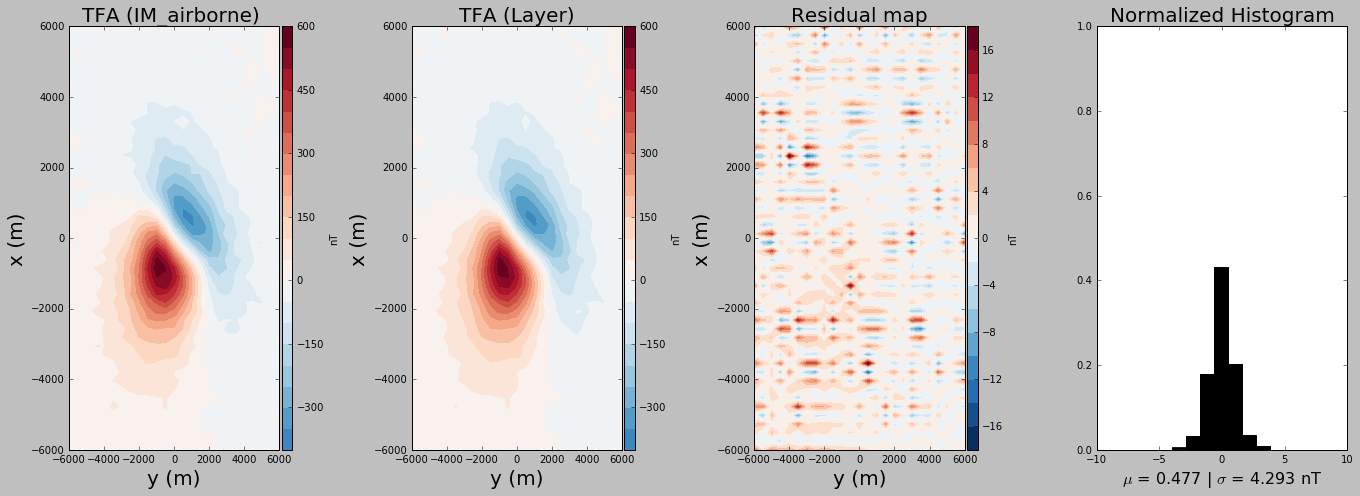

In [30]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(19,7), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_poly_IM_airb'].max(), 
                                   data['tfa_obs_poly_IM_airb'].min(),
                                   tf_pred.max(), tf_pred.min()]).max()

r_ranges = saturation_factor*np.abs([r.max(), r.min()]).max()

plt.subplot(1,4,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_poly_IM_airb'].reshape(airborne['shape']),
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (IM_airborne) ', fontsize=title_font)

plt.subplot(1,4,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             tf_pred.reshape(airborne['shape']), 20,
             cmap='RdBu_r',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (Layer)', fontsize=title_font)

plt.subplot(1,4,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             r.reshape(airborne['shape']), 20,
             cmap='RdBu_r',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)


plt.subplot(1,4,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std), fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('Normalized Histogram',fontsize=title_font)

file_name = 'figs/airborne/noisy_data_fitting_classical_eqlayer_magIM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Magnetic moment within the layer

<function matplotlib.pyplot.show>

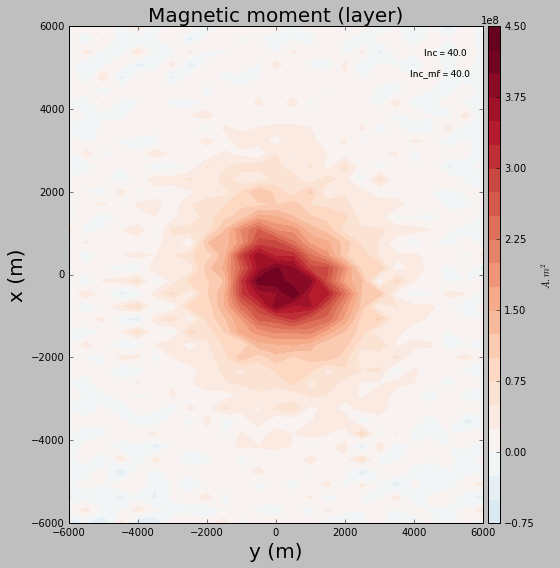

In [31]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

ranges = saturation_factor*np.abs([m.max(), m.min()]).max()

plt.contourf(ys.reshape(shape_layer),
             xs.reshape(shape_layer),
             m.reshape(shape_layer), 20,
             cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.text(4300.,5300.,'Inc = %.1f'% inc_I,family='ubuntu',style='normal')
plt.text(3900.,4800.,'Inc_mf = %.1f'% inc_gf,family='ubuntu',style='normal' )

file_name = 'figs/airborne/noisy_magnetic_moment_classical_eqlayer_magIM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show

## Saved files

In [32]:
with open('reports/report_%s.md' % notebook_name[:st.index(notebook_name, '.')], 'w') as q:
    q.write('# Saved files \n')
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    header = 'Generated by {name} on {date}'.format(date=now, name=notebook_name)
    q.write('\n\n'+header+'\n\n')
    for i, sf in enumerate(saved_files):
        print '%d  %s' % (i+1,sf)
        q.write('*  `%s` \n' % (sf))

1  figs/airborne/noisy_data_fitting_classical_eqlayer_magIM.png
2  figs/airborne/noisy_magnetic_moment_classical_eqlayer_magIM.png
